In [1]:
import os
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn as sk
import lightgbm
SEED = 42
os.chdir(r'D:\AFT\Feature_Engineer_Kaggle_2025')
import numpy as np
import pandas as pd
import os
base_path = r'D:\AFT\Feature_Engineer_Kaggle_2025'  # 原始字符串
# 检查路径是否存在
if os.path.exists(base_path):
    for dirname, _, filenames in os.walk(base_path):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print(f"路径不存在: {base_path}")

D:\AFT\Feature_Engineer_Kaggle_2025\.gitignore
D:\AFT\Feature_Engineer_Kaggle_2025\Factor.py
D:\AFT\Feature_Engineer_Kaggle_2025\filtered_stock_data.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\final_base_factor.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\final_base_polars_factor.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\final_base_polars_factor_sorted.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\lgbm_ts_model.txt
D:\AFT\Feature_Engineer_Kaggle_2025\lgb_model_time_series.txt
D:\AFT\Feature_Engineer_Kaggle_2025\lightgbm_optimized_model.bin
D:\AFT\Feature_Engineer_Kaggle_2025\merged_features.parquet
D:\AFT\Feature_Engineer_Kaggle_2025\multilinear_and_tree-feature.ipynb
D:\AFT\Feature_Engineer_Kaggle_2025\operators.py
D:\AFT\Feature_Engineer_Kaggle_2025\optiver_feature_generator.py
D:\AFT\Feature_Engineer_Kaggle_2025\QUICK_START.md
D:\AFT\Feature_Engineer_Kaggle_2025\README.md
D:\AFT\Feature_Engineer_Kaggle_2025\requirements.txt
D:\AFT\Feature_Engineer_Kaggle_2025\run_example.sh
D:\AFT\Fe

In [4]:
import polars as pl
X = pl.read_parquet("final_base_factor.parquet")

In [5]:
last_column = X.columns[-1]
print(f"最后一列名称: {last_column}")

最后一列名称: target


In [6]:
X = X.with_columns([
    pl.col('target').fill_null(0)  # 将target列的空值填充为0
])
print(f"target列空值数量: {X['target'].null_count()}")

target列空值数量: 0


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import polars as pl
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# 随机抽样10%的样本，但保持时间顺序
sample_ratio = 0.85
if sample_ratio < 1.0:
    total_rows = len(X)
    sample_size = int(total_rows * sample_ratio)
    
    # 方法1: 随机选择10%的索引，然后排序以保持时间顺序
    random_indices = np.random.choice(total_rows, size=sample_size, replace=False)
    random_indices = np.sort(random_indices)  # 保持时间顺序
    
    X = X[random_indices]
    
    print(f"从 {total_rows} 行数据中随机抽样 {sample_size} 行 ({sample_ratio*100}%)")

In [7]:
y= X.select(X.columns[-1])
X= X.select(X.columns[:-1])

训练集: (1904720, 326), 验证集: (476180, 326)
=========== 训练模型并记录学习曲线 ===========
[50]	train's l1: 5.78152	val's l1: 5.20779
[100]	train's l1: 5.74731	val's l1: 5.18777
[150]	train's l1: 5.7295	val's l1: 5.17908
[200]	train's l1: 5.71769	val's l1: 5.1753
[250]	train's l1: 5.70907	val's l1: 5.17291
[300]	train's l1: 5.70197	val's l1: 5.17162
[350]	train's l1: 5.69544	val's l1: 5.171
[400]	train's l1: 5.68961	val's l1: 5.17054
[450]	train's l1: 5.68439	val's l1: 5.17028
[500]	train's l1: 5.67923	val's l1: 5.16991

最佳停止点分析:
基于MAE差异最小 - 轮数: 490, 差异: 0.5101
基于验证集MAE最小 - 轮数: 490, MAE: 5.1700


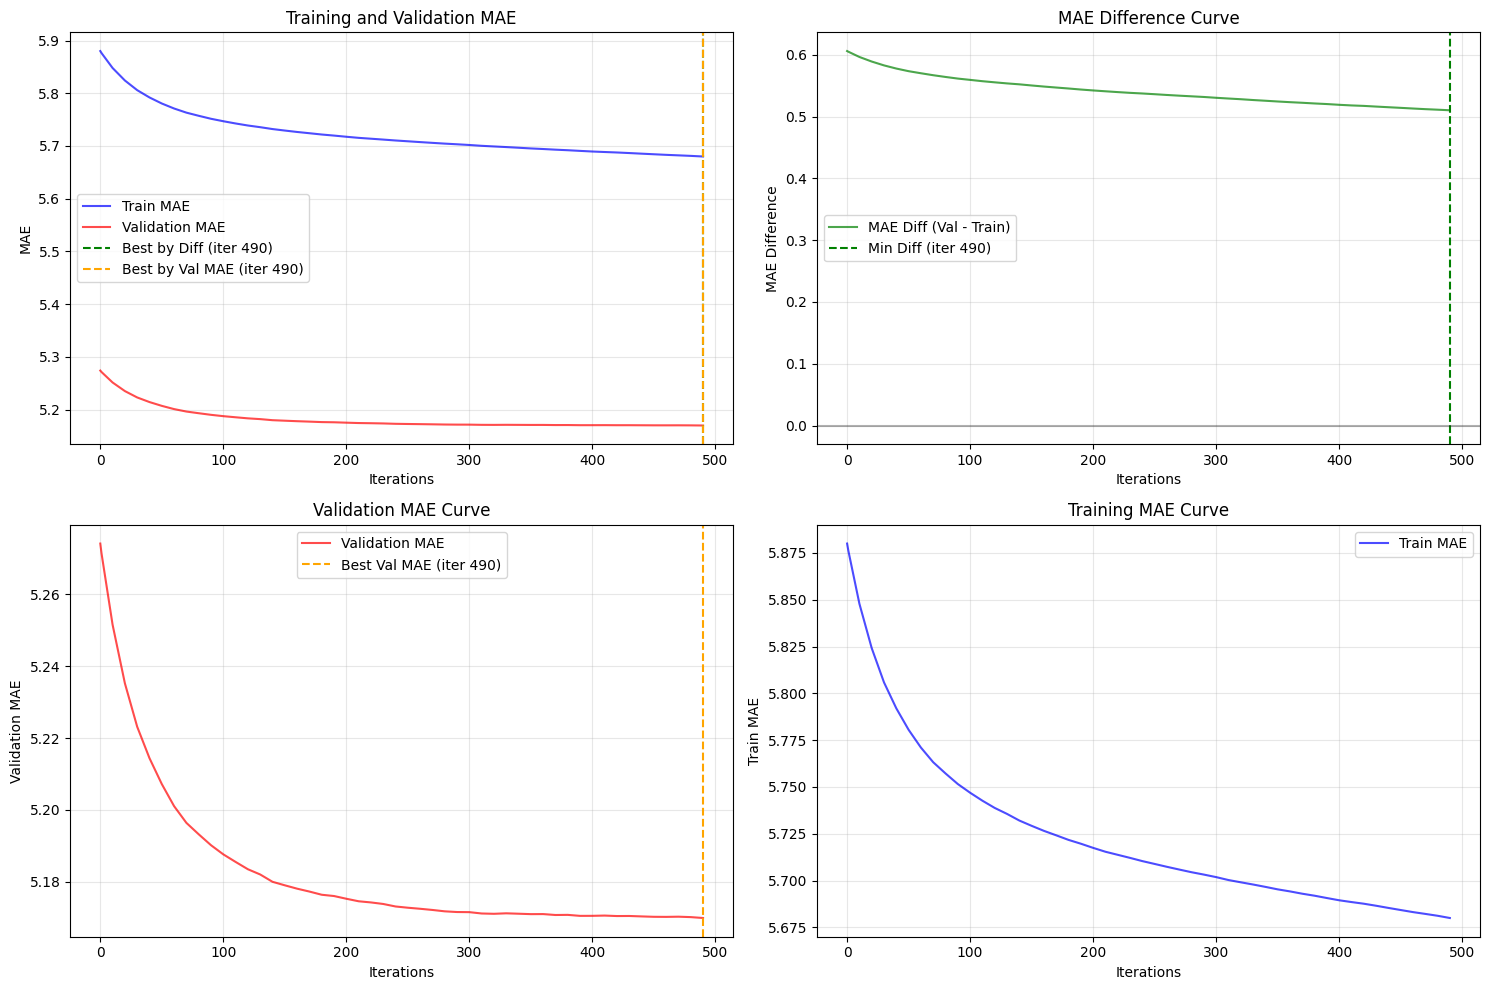


=========== 使用最佳轮数 (490) 重新训练最终模型 ===========
[50]	valid_0's l1: 5.66723
[100]	valid_0's l1: 5.63521
[150]	valid_0's l1: 5.61922
[200]	valid_0's l1: 5.60931
[250]	valid_0's l1: 5.60165
[300]	valid_0's l1: 5.59517
[350]	valid_0's l1: 5.58942
[400]	valid_0's l1: 5.5841
[450]	valid_0's l1: 5.57936
最终模型已保存，使用 490 轮迭代

============== 最终模型性能 ==============
RMSE: 8.1413
MAE: 5.5757
使用轮数: 490

过拟合分析:
训练集MAE: 5.6888
验证集MAE: 5.1230
过拟合差距: -0.5658
✅ 模型泛化能力良好


In [9]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
feature_columns = [c for c in X.columns if c not in ['stock_id', 'date_id', 'seconds_in_bucket']]
# 准备数据
X_full = X.select(feature_columns).to_numpy()
y_full = y.to_numpy().flatten()
del X, y  # 释放内存
# 分割训练集和验证集（时间序列数据按顺序分割）
split_ratio = 0.8
split_point = int(len(X_full) * split_ratio)

X_train = X_full[:split_point]
y_train = y_full[:split_point]
X_val = X_full[split_point:]
y_val = y_full[split_point:]

print(f"训练集: {X_train.shape}, 验证集: {X_val.shape}")

# LightGBM 参数
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 1e-3,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'verbosity': -1,
    'seed': 42
}

# 创建数据集
train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_columns)
val_data = lgb.Dataset(X_val, label=y_val, feature_name=feature_columns, reference=train_data)

# 用于记录训练过程的回调函数
eval_results = {}

def record_evaluation(env):
    """记录每轮迭代的评估结果"""
    if env.iteration % 10 == 0 or env.iteration == 1:  # 每10轮记录一次
        eval_results.setdefault('train_mae', []).append(env.evaluation_result_list[0][2])
        eval_results.setdefault('val_mae', []).append(env.evaluation_result_list[1][2])
        eval_results.setdefault('iterations', []).append(env.iteration)

print("=========== 训练模型并记录学习曲线 ===========")

# 训练模型（不提前停止，记录所有轮次）
model_with_history = lgb.train(
    params,
    train_data,
    num_boost_round=500,  # 训练足够多的轮次
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    callbacks=[
        record_evaluation,
        lgb.log_evaluation(50)  # 每50轮打印一次
    ]
)

# 提取记录的结果
iterations = eval_results['iterations']
train_mae = eval_results['train_mae']
val_mae = eval_results['val_mae']

# 计算训练集和验证集的MAE差异
mae_diff = [abs(val_mae[i] - train_mae[i]) for i in range(len(train_mae))]

# 找到MAE差异最小的点（最不容易过拟合的点）
min_diff_idx = np.argmin(mae_diff)
best_iteration_by_diff = iterations[min_diff_idx]
best_mae_diff = mae_diff[min_diff_idx]

# 找到验证集MAE最小的点
best_val_idx = np.argmin(val_mae)
best_iteration_by_val = iterations[best_val_idx]
best_val_mae = val_mae[best_val_idx]

print(f"\n最佳停止点分析:")
print(f"基于MAE差异最小 - 轮数: {best_iteration_by_diff}, 差异: {best_mae_diff:.4f}")
print(f"基于验证集MAE最小 - 轮数: {best_iteration_by_val}, MAE: {best_val_mae:.4f}")

# 绘制学习曲线
plt.figure(figsize=(15, 10))

# 子图1: 训练集和验证集MAE
plt.subplot(2, 2, 1)
plt.plot(iterations, train_mae, 'b-', label='Train MAE', alpha=0.7)
plt.plot(iterations, val_mae, 'r-', label='Validation MAE', alpha=0.7)
plt.axvline(x=best_iteration_by_diff, color='g', linestyle='--', label=f'Best by Diff (iter {best_iteration_by_diff})')
plt.axvline(x=best_iteration_by_val, color='orange', linestyle='--', label=f'Best by Val MAE (iter {best_iteration_by_val})')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2: MAE差异曲线
plt.subplot(2, 2, 2)
plt.plot(iterations, mae_diff, 'g-', label='MAE Diff (Val - Train)', alpha=0.7)
plt.axvline(x=best_iteration_by_diff, color='g', linestyle='--', label=f'Min Diff (iter {best_iteration_by_diff})')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('MAE Difference')
plt.title('MAE Difference Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图3: 验证集MAE曲线
plt.subplot(2, 2, 3)
plt.plot(iterations, val_mae, 'r-', label='Validation MAE', alpha=0.7)
plt.axvline(x=best_iteration_by_val, color='orange', linestyle='--', label=f'Best Val MAE (iter {best_iteration_by_val})')
plt.xlabel('Iterations')
plt.ylabel('Validation MAE')
plt.title('Validation MAE Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图4: 训练集MAE曲线
plt.subplot(2, 2, 4)
plt.plot(iterations, train_mae, 'b-', label='Train MAE', alpha=0.7)
plt.xlabel('Iterations')
plt.ylabel('Train MAE')
plt.title('Training MAE Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 使用最佳轮数重新训练最终模型
print(f"\n=========== 使用最佳轮数 ({best_iteration_by_diff}) 重新训练最终模型 ===========")

final_model = lgb.train(
    params,
    lgb.Dataset(X_full, label=y_full, feature_name=feature_columns),
    num_boost_round=best_iteration_by_diff,
    valid_sets=[lgb.Dataset(X_full, label=y_full)],
    callbacks=[lgb.log_evaluation(50)]
)

# 保存模型
final_model.save_model('lightgbm_optimized_model.bin')
print(f"最终模型已保存，使用 {best_iteration_by_diff} 轮迭代")

# 最终评估
final_preds = final_model.predict(X_full)
final_rmse = np.sqrt(mean_squared_error(y_full, final_preds))
final_mae = mean_absolute_error(y_full, final_preds)

print(f"\n============== 最终模型性能 ==============")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"使用轮数: {best_iteration_by_diff}")
print("==========================================")

# 分析过拟合程度
train_preds = final_model.predict(X_train)
val_preds = final_model.predict(X_val)

train_mae_final = mean_absolute_error(y_train, train_preds)
val_mae_final = mean_absolute_error(y_val, val_preds)
overfitting_gap = val_mae_final - train_mae_final

print(f"\n过拟合分析:")
print(f"训练集MAE: {train_mae_final:.4f}")
print(f"验证集MAE: {val_mae_final:.4f}")
print(f"过拟合差距: {overfitting_gap:.4f}")

if overfitting_gap > 0.1 * train_mae_final:
    print("⚠️  存在明显过拟合，建议增加正则化参数")
else:
    print("✅ 模型泛化能力良好")

In [6]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import polars as pl
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 特征列
feature_columns = [c for c in X.columns if c not in ['stock_id', 'date_id', 'seconds_in_bucket']]

# LightGBM 参数
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 1e-3,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'verbosity': -1,
    'seed': 42
}

# 5 折时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=5)
fold = 1
rmse_list = []
mae_list = []

# 获取总行数
n_samples = len(X)

for train_idx, val_idx in tscv.split(range(n_samples)):
    print(f"\n=========== 第 {fold} 折 ===========")
    
    # 使用 Polars 切片，避免一次性加载大数组
    X_train = X[train_idx].select(feature_columns).to_numpy()
    y_train = y[train_idx].to_numpy().flatten()
    X_val = X[val_idx].select(feature_columns).to_numpy()
    y_val = y[val_idx].to_numpy().flatten()
    
    print(f"训练集: {X_train.shape}, 验证集: {X_val.shape}")
    
    # 创建 lightgbm dataset
    train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_columns)
    val_data = lgb.Dataset(X_val, label=y_val, feature_name=feature_columns)
    
    # 训练
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,  # 减少轮数
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=True),  # 提前停止
            lgb.log_evaluation(100)
        ]
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    print(f"[Fold {fold}] RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    rmse_list.append(rmse)
    mae_list.append(mae)
    fold += 1

print("\n============== 5 折交叉验证结果 ==============")
print(f"平均 RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"平均 MAE : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print("============================================")


=========== 第 1 折 ===========
训练集: (742048, 210), 验证集: (742047, 210)
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 1.11479	valid's l1: 1.52901
[200]	train's l1: 0.347512	valid's l1: 0.527577
[300]	train's l1: 0.184886	valid's l1: 0.327909
[400]	train's l1: 0.15389	valid's l1: 0.296543
[500]	train's l1: 0.144491	valid's l1: 0.29105
Early stopping, best iteration is:
[530]	train's l1: 0.142406	valid's l1: 0.290056
[Fold 1] RMSE = 2.1036, MAE = 0.2901

=========== 第 2 折 ===========
训练集: (1484095, 210), 验证集: (742047, 210)
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 1.31311	valid's l1: 1.41552
[200]	train's l1: 0.395897	valid's l1: 0.429519
[300]	train's l1: 0.204818	valid's l1: 0.224627
[400]	train's l1: 0.171041	valid's l1: 0.19103
[500]	train's l1: 0.161379	valid's l1: 0.183777
[600]	train's l1: 0.156931	valid's l1: 0.181664
[700]	train's l1: 0.153487	valid's l1: 0.180393
[800]	train's l1: 0.150858	valid's l1: 0.179753


In [7]:
model.save_model("lgbm_ts_model.txt")

In [8]:
# import shap
# import matplotlib.pyplot as plt
# # 使用Polars选择特征列并转换为numpy
# X_sample_np = X.select(feature_columns).to_numpy()
# shap_k = model.predict(
#     X_sample_np,
#     pred_contrib=True,
#     approximate=True,
#     num_iteration=model.num_trees()//5
# )
# shap_k = shap_k[:, :-1]  # 移除最后一个偏置项
# # 创建SHAP解释器
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_sample_np)
# # 1. 输出SHAP摘要图
# plt.figure(figsize=(10, 8))
# shap.summary_plot(shap_values, X_sample_np, feature_names=feature_columns, show=False)
# plt.title('SHAP Summary Plot')
# plt.tight_layout()
# plt.show()
# # 2. 输出特征重要性条形图
# plt.figure(figsize=(10, 8))
# shap.summary_plot(shap_values, X_sample_np, feature_names=feature_columns, plot_type="bar", show=False)
# plt.title('SHAP Feature Importance')
# plt.tight_layout()
# plt.show()
# # 3. 计算并输出前20个最重要的特征
# shap_importance = pl.DataFrame({
#     'feature': feature_columns,
#     'importance': np.abs(shap_values).mean(axis=0)
# }).sort('importance', descending=True)
# print("SHAP特征重要性 Top 20:")
# print(shap_importance.head(20))

KeyboardInterrupt: 

[LightGBM] [Warning] Unknown parameter: approximate
SHAP特征重要性 Top 20:
shape: (20, 2)
┌─────────────────────────────────┬────────────┐
│ feature                         ┆ importance │
│ ---                             ┆ ---        │
│ str                             ┆ f64        │
╞═════════════════════════════════╪════════════╡
│ cs_zscore_add_composite_pressu… ┆ 0.229682   │
│ ts_diff_wap_trend_macd_dif_imb… ┆ 0.224288   │
│ cs_zscore_add_wap_wap_mid_devi… ┆ 0.177705   │
│ cs_zscore_add_wap_trend_log_re… ┆ 0.145521   │
│ cs_cross_imb1_reference_price_… ┆ 0.124923   │
│ …                               ┆ …          │
│ wap_trend_mock_3                ┆ 0.054674   │
│ cs_zscore_add_wap_trend_veloci… ┆ 0.052099   │
│ cs_zscore_add_imb1_near_price_… ┆ 0.048489   │
│ cs_cross_ask_size_wap_trend_ve… ┆ 0.040685   │
│ cs_cross_bid_notional_wap_tren… ┆ 0.039646   │
└─────────────────────────────────┴────────────┘


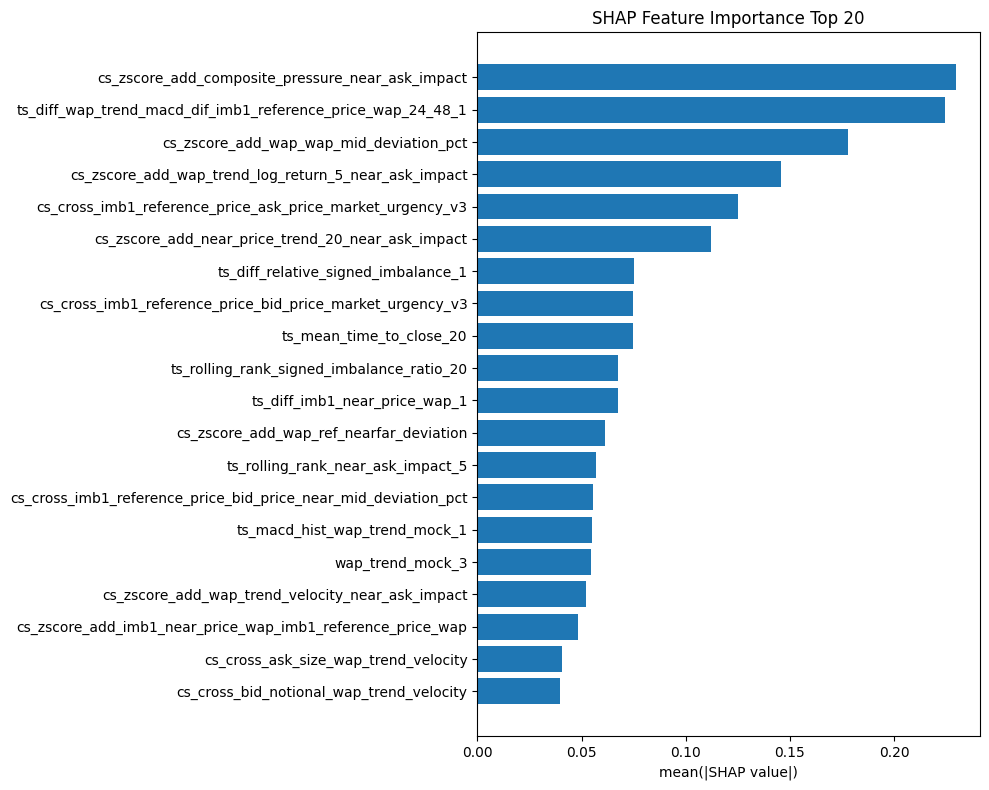

In [8]:
# 使用Polars选择特征列并转换为numpy
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import polars as pl
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
model = lgb.Booster(model_file='lightgbm_optimized_model.bin')
feature_columns = [c for c in X.columns if c not in ['stock_id', 'date_id', 'seconds_in_bucket']]
X_sample_np = X.select(feature_columns).to_numpy()
shap_k = model.predict(
    X_sample_np,
    pred_contrib=True,
    approximate=True,
    num_iteration=int(model.num_trees()) )
shap_k = shap_k[:, :-1]  # 移除最后一个偏置项
# 转换为Polars DataFrame
shap_df = pl.DataFrame(shap_k, schema=feature_columns)
# 计算每个特征的绝对SHAP值均值
shap_importance = pl.DataFrame({
    'feature': feature_columns,
    'importance': [shap_df[col].abs().mean() for col in feature_columns]
}).sort('importance', descending=True)
# 简要输出前20个最重要的特征
print("SHAP特征重要性 Top 20:")
print(shap_importance.head(20))
# 绘制简单的条形图
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
top_20 = shap_importance.head(20).to_pandas()
plt.barh(range(20), top_20['importance'][::-1])
plt.yticks(range(20), top_20['feature'][::-1])
plt.xlabel('mean(|SHAP value|)')
plt.title('SHAP Feature Importance Top 20')
plt.tight_layout()
plt.show()

In [9]:
shap_importance.write_csv("shap_feature_importance.csv")

In [10]:
shap_df.write_parquet('shap_values.parquet')


In [3]:
import polars as pl
shap_importance = pl.read_csv("shap_feature_importance.csv")
X = pl.read_parquet("final_base_factor.parquet")
feature_columns = shap_importance[:100, 0].to_list()  # 获取所有特征名
selected_columns = [col for col in feature_columns if col in X.columns] + ['target'] 
selected_data = X.select(selected_columns)

In [ ]:
selected_data.write_parquet("selected_features_with_target.parquet")


In [20]:
def shap_compare(model, X_train, K=50):

    import numpy as np
    import pandas as pd
    import time
    import shap
    import matplotlib.pyplot as plt
    from scipy.stats import spearmanr

    # ====================== 参数处理 ======================
    N = min(100000, len(X_train))   
    X_sample = X_train[:N]

    if isinstance(X_sample, pd.DataFrame):
        feature_names = X_sample.columns
    else:
        feature_names = [f"f{i}" for i in range(X_sample.shape[1])]
        X_sample = pd.DataFrame(X_sample, columns=feature_names)

    # ====================== 1. full SHAP (LightGBM 内置) ======================
    t0 = time.time()
    shap_full = model.predict(
        X_sample,
        pred_contrib=True,
        approximate=True,
        num_iteration=None 
    )
    shap_full = shap_full[:, :-1]  # 去掉 bias
    t1 = time.time()

    # ====================== 2. K SHAP (LightGBM 内置) ======================
    t2 = time.time()
    shap_k = model.predict(
        X_sample,
        pred_contrib=True,
        approximate=True,
        num_iteration=K
    )
    shap_k = shap_k[:, :-1]
    t3 = time.time()

    # ====================== 3. SHAP 包 TreeExplainer ======================
    t4 = time.time()
    explainer = shap.TreeExplainer(model)
    shap_values_shap = explainer.shap_values(X_sample)
    t5 = time.time()

    if isinstance(shap_values_shap, list):  # 二分类
        shap_values_shap = shap_values_shap[1]

    # ====================== 4. 特征重要性对比 ======================
    imp_full = np.mean(np.abs(shap_full), axis=0)
    imp_k = np.mean(np.abs(shap_k), axis=0)*2
    imp_shap = np.mean(np.abs(shap_values_shap), axis=0)

    df_imp = pd.DataFrame({
        "feature": feature_names,
        "full_shap": imp_full,
        f"k{K}_shap": imp_k,
        "shap_package": imp_shap
    })

    df_imp["rank_full"] = df_imp["full_shap"].rank(ascending=False)
    df_imp[f"rank_k{K}"] = df_imp[f"k{K}_shap"].rank(ascending=False)
    df_imp["rank_shap"] = df_imp["shap_package"].rank(ascending=False)

    df_imp["rank_diff_k"] = df_imp["rank_full"] - df_imp[f"rank_k{K}"]
    df_imp["rank_diff_shap"] = df_imp["rank_full"] - df_imp["rank_shap"]

    df_imp = df_imp.sort_values("rank_full").reset_index(drop=True)

    # ====================== 打印速度结果 ======================
    print("======= 速度对比（秒） =======")
    print(f"1. Full SHAP (LightGBM内置): {t1 - t0:.3f} s")
    print(f"2. K={K} SHAP (LightGBM内置): {t3 - t2:.3f} s")
    print(f"3. SHAP包 TreeExplainer: {t5 - t4:.3f} s")
    print(f"加速倍率 (Full vs K={K}): {(t1 - t0)/(t3 - t2):.2f}x")
    print(f"加速倍率 (SHAP包 vs K={K}): {(t5 - t4)/(t3 - t2):.2f}x")

    # ====================== 前 20 特征 ======================
    print("\n======= 前 20 个特征的重要性对比 =======")
    display(df_imp.head(20))

    # ====================== 5. SHAP 相关性分析 ======================
    print("\n======= 方法间相关性 =======")
    correlation_matrix = df_imp[['full_shap', f'k{K}_shap', 'shap_package']].corr()
    print(correlation_matrix)

    # ====================== 6. 排名相关性 ======================
    spearman_full_k, _ = spearmanr(df_imp["rank_full"], df_imp[f"rank_k{K}"])
    spearman_full_shap, _ = spearmanr(df_imp["rank_full"], df_imp["rank_shap"])
    spearman_k_shap, _ = spearmanr(df_imp[f"rank_k{K}"], df_imp["rank_shap"])

    print("\n======= 排名一致性 (Spearman相关系数) =======")
    print(f"Full SHAP vs K={K} SHAP: {spearman_full_k:.4f}")
    print(f"Full SHAP vs SHAP包: {spearman_full_shap:.4f}")
    print(f"K={K} SHAP vs SHAP包: {spearman_k_shap:.4f}")

    # ====================== 7. 可视化对比 ======================
    top_features = df_imp.head(10)['feature'].values
    top_indices = [list(feature_names).index(f) for f in top_features]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].barh(range(10), imp_full[top_indices])
    axes[0].set_title('Full SHAP (LightGBM)')
    axes[0].set_yticks(range(10))
    axes[0].set_yticklabels(top_features)

    axes[1].barh(range(10), imp_k[top_indices])
    axes[1].set_title(f'K={K} SHAP (LightGBM)')
    axes[1].set_yticks(range(10))
    axes[1].set_yticklabels(top_features)

    axes[2].barh(range(10), imp_shap[top_indices])
    axes[2].set_title('SHAP Package')
    axes[2].set_yticks(range(10))
    axes[2].set_yticklabels(top_features)

    plt.tight_layout()
    plt.show()

    return df_imp

======= 速度对比（秒） =======
1. Full SHAP (LightGBM内置): 2.660 s
2. K=49 SHAP (LightGBM内置): 0.411 s
3. SHAP包 TreeExplainer: 2.958 s
加速倍率 (Full vs K=49): 6.46x
加速倍率 (SHAP包 vs K=49): 7.19x

======= 前 20 个特征的重要性对比 =======


,feature,full_shap,k49_shap,shap_package,rank_full,rank_k49,rank_shap,rank_diff_k,rank_diff_shap
0,mid_price_corr,1.386547,1.590048,1.386547,1.0,1.0,1.0,0.0,0.0
1,wap_x,0.611205,0.735135,0.611205,2.0,2.0,2.0,0.0,0.0
2,reference_price_corr,0.405377,0.362059,0.405377,3.0,4.0,3.0,-1.0,0.0
3,relative_to_max,0.368162,0.386264,0.368162,4.0,3.0,4.0,1.0,0.0
4,relative_to_min,0.361192,0.357156,0.361192,5.0,5.0,5.0,0.0,0.0
5,time_id,0.223892,0.022389,0.223892,6.0,28.0,6.0,-22.0,0.0
6,imb_s1,0.159925,0.152130,0.159925,7.0,7.0,7.0,0.0,0.0
7,ask_price_minus_wap,0.142458,0.194274,0.142458,8.0,6.0,8.0,2.0,0.0
8,BBO_size_imbalance,0.134406,0.071203,0.134406,9.0,10.0,9.0,-1.0,0.0
9,reference_price_minus_wap,0.102584,0.043605,0.102584,10.0,18.0,10.0,-8.0,0.0



======= 方法间相关性 =======
              full_shap  k49_shap  shap_package
full_shap      1.000000  0.986321      1.000000
k49_shap       0.986321  1.000000      0.986321
shap_package   1.000000  0.986321      1.000000

======= 排名一致性 (Spearman相关系数) =======
Full SHAP vs K=49 SHAP: 0.8573
Full SHAP vs SHAP包: 1.0000
K=49 SHAP vs SHAP包: 0.8573


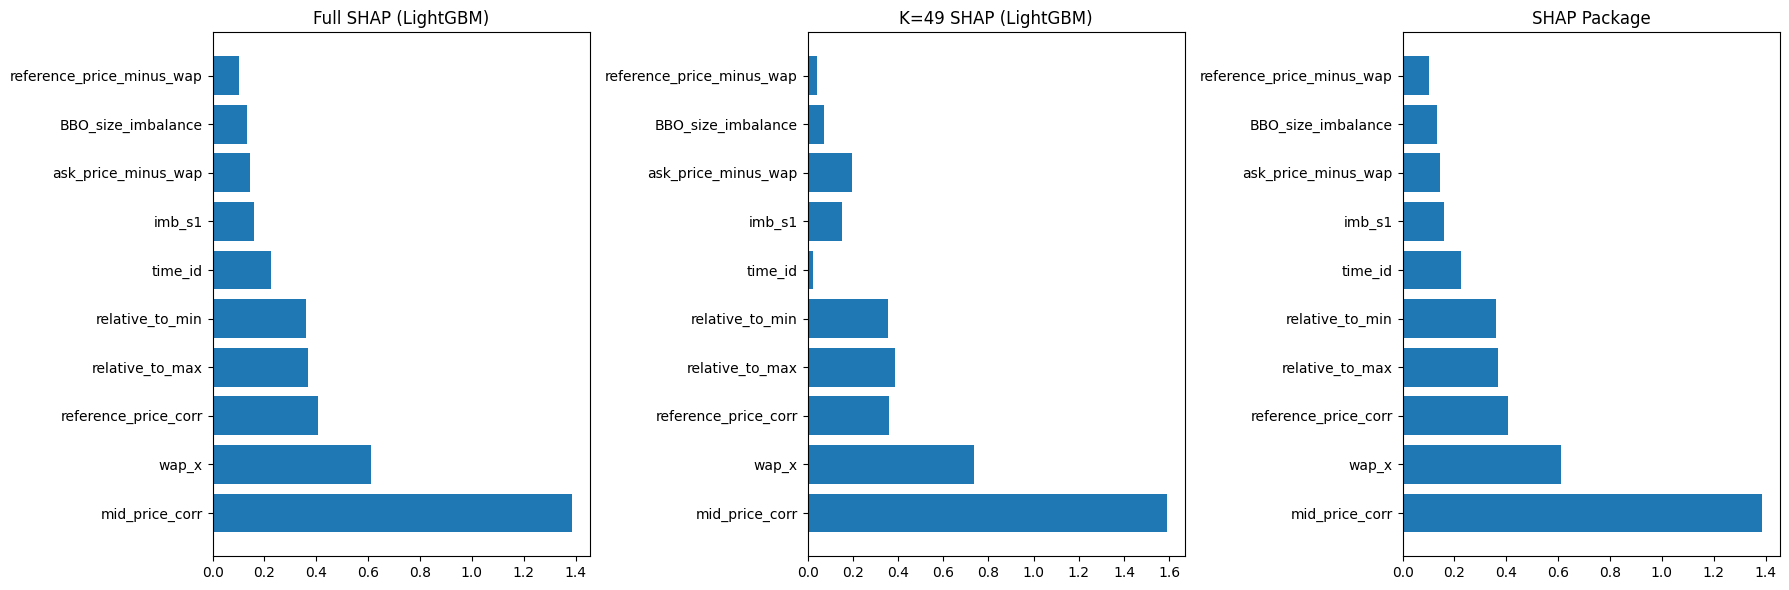

,feature,full_shap,k49_shap,shap_package,rank_full,rank_k49,rank_shap,rank_diff_k,rank_diff_shap
0,mid_price_corr,1.386547,1.590048,1.386547,1.0,1.0,1.0,0.0,0.0
1,wap_x,0.611205,0.735135,0.611205,2.0,2.0,2.0,0.0,0.0
2,reference_price_corr,0.405377,0.362059,0.405377,3.0,4.0,3.0,-1.0,0.0
3,relative_to_max,0.368162,0.386264,0.368162,4.0,3.0,4.0,1.0,0.0
4,relative_to_min,0.361192,0.357156,0.361192,5.0,5.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
143,far_price_bid_price_imb,0.000000,0.000000,0.000000,144.0,126.5,144.0,17.5,0.0
144,high_volume_imbalance_size,0.000000,0.000000,0.000000,144.0,126.5,144.0,17.5,0.0
145,high_volume,0.000000,0.000000,0.000000,144.0,126.5,144.0,17.5,0.0
146,reference_price_near_price_imb,0.000000,0.000000,0.000000,144.0,126.5,144.0,17.5,0.0


In [17]:
shap_compare(model, X_val[feature_columns], K=model.num_trees()//5)